# SENTIMENTAL ANALYSIS ON MOVIE REVIEWS

### Import the python libraries

In [1]:
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np 
import pandas as pd
import nltk

from tensorflow import keras
from keras.preprocessing.text import text_to_word_sequence
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier
from wordcloud import WordCloud

### Reading the csv files

In [2]:
trainingData = pd.read_csv("./dataset/train.csv")
testing_data = pd.read_csv("./dataset/test.csv")

### Data analysis

In [3]:
trainingData.head()

,PhraseId,SentenceId,Phrase,Sentiment
0,1,1,A series of escapades demonstrating the adage ...,1
1,2,1,A series of escapades demonstrating the adage ...,2
2,3,1,A series,2
3,4,1,A,2
4,5,1,series,2


In [4]:
print("Count - training data", len(trainingData))
print("Count - testing data", len(testing_data))

Count - training data 156060
Count - testing data 66292


In [5]:
trainingData.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 156060 entries, 0 to 156059
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   PhraseId    156060 non-null  int64 
 1   SentenceId  156060 non-null  int64 
 2   Phrase      156060 non-null  object
 3   Sentiment   156060 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 4.8+ MB


In [6]:
trainingData.describe()

,PhraseId,SentenceId,Sentiment
count,156060.000000,156060.000000,156060.000000
mean,78030.500000,4079.732744,2.063578
std,45050.785842,2502.764394,0.893832
min,1.000000,1.000000,0.000000
25%,39015.750000,1861.750000,2.000000
50%,78030.500000,4017.000000,2.000000
75%,117045.250000,6244.000000,3.000000
max,156060.000000,8544.000000,4.000000


In [7]:
trainingData.columns

Index(['PhraseId', 'SentenceId', 'Phrase', 'Sentiment'], dtype='object')

In [8]:
target_category = trainingData['Sentiment'].unique()
target_category=list(map(str,target_category))
print(target_category)

['1', '2', '3', '4', '0']


In [9]:
trainingData = trainingData[['Phrase','Sentiment']]
trainingData.head()

,Phrase,Sentiment
0,A series of escapades demonstrating the adage ...,1
1,A series of escapades demonstrating the adage ...,2
2,A series,2
3,A,2
4,series,2


In [10]:
trainingData.tail(5)

,Phrase,Sentiment
156055,Hearst 's,2
156056,forced avuncular chortles,1
156057,avuncular chortles,3
156058,avuncular,2
156059,chortles,2


<AxesSubplot:xlabel='Sentiment'>

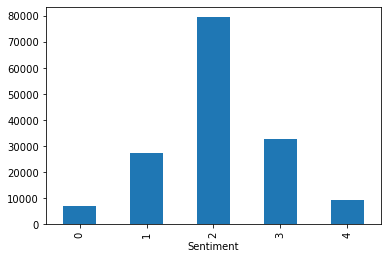

In [11]:
trainingData.groupby("Sentiment").Sentiment.count().plot.bar(ylim=0)

### Data Pre-processing

In [12]:
# transforming sentiments to required classes
trainingData.loc[(trainingData['Sentiment'] == 0) | (trainingData['Sentiment'] == 1) , 'Sentiment'] = 0
trainingData.loc[trainingData['Sentiment'] == 2 , 'Sentiment'] = 1
trainingData.loc[(trainingData['Sentiment'] == 3) | (trainingData['Sentiment'] == 4) , 'Sentiment'] = 2


In [13]:
# training data after conversion
trainingData.head()

,Phrase,Sentiment
0,A series of escapades demonstrating the adage ...,0
1,A series of escapades demonstrating the adage ...,1
2,A series,1
3,A,1
4,series,1


<AxesSubplot:xlabel='Sentiment'>

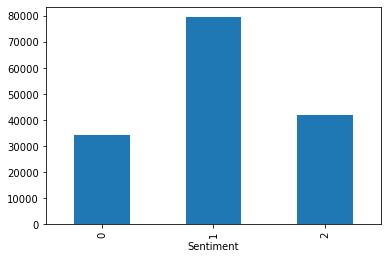

In [14]:
# Sentiment distribution
trainingData.groupby("Sentiment").Sentiment.count().plot.bar(ylim=0)

### Pie chart distribution

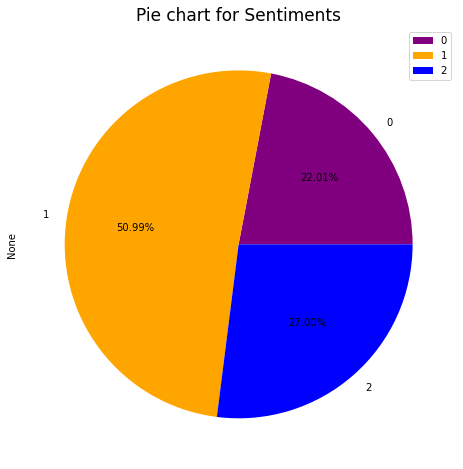

In [15]:
category = trainingData.groupby('Sentiment').size()

category.plot(kind='pie', subplots=True, figsize=(10, 8), autopct = "%.2f%%", colors=['purple','orange','blue'])
plt.title("Pie chart for Sentiments",fontsize=17)
plt.legend()
plt.show()

In [16]:
phrase = trainingData['Phrase']
sentiment = trainingData["Sentiment"]

In [17]:
def dataPreProcessing(text): 

    #read text
    text = str(text)
    # remove ' quotes
    text = text.replace("'", "")
    
    #word tokenization using text-to-word-sequence from keras
    tokenizedTrainingData = text_to_word_sequence(text,filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n',split=" ")

    #remove stop words if any
    stopWords = set(stopwords.words('english'))
    stopwordremove = [i for i in tokenizedTrainingData if not i in stopWords]

    #join words into sentence and remove numbers if any
    textwithoutStopwords = ' '.join(stopwordremove)
    textwithoutNumbers = ''.join(c for c in textwithoutStopwords if not c.isdigit())
        
    #Stemming
    stemmer= PorterStemmer()
    stemInput=nltk.word_tokenize(textwithoutNumbers)
    stemmedText=' '.join([stemmer.stem(word) for word in stemInput])
    
    #lemmatization

    lemmatizer = WordNetLemmatizer()
    def get_wordnet_pos(word):
        tag = nltk.pos_tag([word])[0][1][0].upper()
        tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}

        return tag_dict.get(tag, wordnet.NOUN)

    lemmatizerInput = nltk.word_tokenize(stemmedText)
    lemmatizedText= ' '.join([lemmatizer.lemmatize(w, get_wordnet_pos(w)) for w in lemmatizerInput])
    
    return lemmatizedText

In [18]:
trainingData['Phrase'] = trainingData['Phrase'].apply(dataPreProcessing)
phrase = trainingData['Phrase']
sentiment = trainingData['Sentiment']
phrase.head()

0    seri escapad demonstr adag good goo also good ...
1                  seri escapad demonstr adag good goo
2                                                 seri
3                                                     
4                                                 seri
Name: Phrase, dtype: object

### Word Cloud

In [19]:
def wordCollection(phrase, sentiment):
    words = []
    for i in phrase[phrase['Sentiment'] == sentiment]['Phrase'].str.split():
        for j in i:
            words.append(j)
    return words

negative = wordCollection(trainingData,0)
neutral = wordCollection(trainingData,1)
positive = wordCollection(trainingData,2)

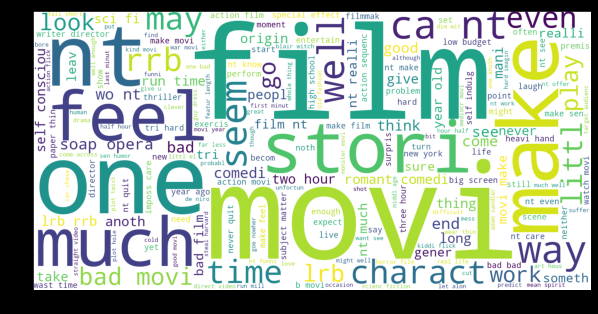

In [20]:
#-ve words cloud
wordCloud = WordCloud(background_color="white", width=1600, height=800).generate(' '.join(negative))
plt.figure(figsize=(10,10), facecolor='k')
plt.imshow(wordCloud)

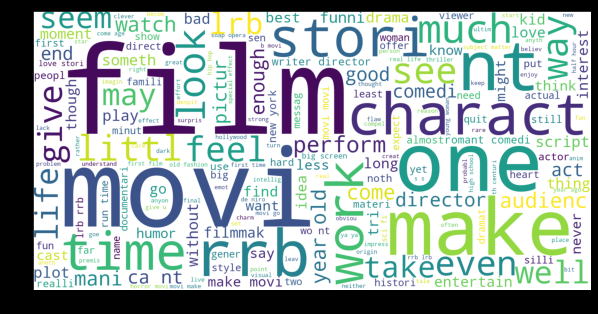

In [21]:
#neutral words cloud
wordCloud = WordCloud(background_color="white", width=1600, height=800).generate(' '.join(neutral))
plt.figure(figsize=(10,10), facecolor='k')
plt.imshow(wordCloud)

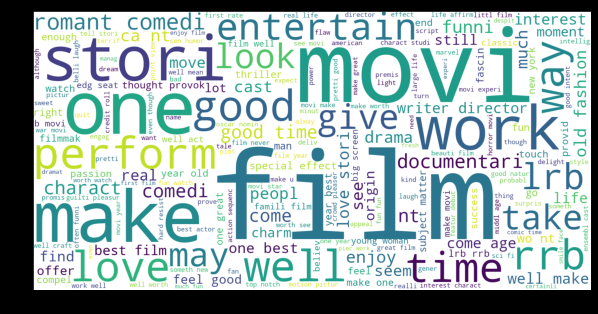

In [22]:
#+ve words cloud
wordCloud = WordCloud(background_color="white", width=1600, height=800).generate(' '.join(positive))
plt.figure(figsize=(10,10), facecolor='k')
plt.imshow(wordCloud)

In [23]:
list_data = list(zip(phrase, sentiment))
trainingData = pd.DataFrame(list_data,columns = ['Phrase', 'Sentiment'])
trainingData.head(20)

,Phrase,Sentiment
0,seri escapad demonstr adag good goo also good ...,0
1,seri escapad demonstr adag good goo,1
2,seri,1
3,,1
4,seri,1
5,escapad demonstr adag good goo,1
6,,1
7,escapad demonstr adag good goo,1
8,escapad,1
9,demonstr adag good goo,1


In [24]:
trainingData['Phrase'].replace('', np.nan, inplace=True)
trainingData.dropna(subset = ["Phrase"], inplace=True)
trainingData.head(20)

,Phrase,Sentiment
0,seri escapad demonstr adag good goo also good ...,0
1,seri escapad demonstr adag good goo,1
2,seri,1
4,seri,1
5,escapad demonstr adag good goo,1
7,escapad demonstr adag good goo,1
8,escapad,1
9,demonstr adag good goo,1
10,demonstr adag,1
11,demonstr,1


In [25]:
print("Count after removing empty rows are: ",len(trainingData))

Count after removing empty rows are:  154683


In [26]:
phrase = trainingData['Phrase']
sentiment = trainingData['Sentiment']
phrase.head()

0    seri escapad demonstr adag good goo also good ...
1                  seri escapad demonstr adag good goo
2                                                 seri
4                                                 seri
5                       escapad demonstr adag good goo
Name: Phrase, dtype: object

### Train_Test_Split into 70:30

In [27]:
X_train, X_test, Y_train, Y_test = train_test_split(phrase,sentiment, test_size = 0.3, random_state = 60,shuffle=True, stratify=sentiment)
print("Count of X_train",len(X_train))
print("Count of X_test",len(X_test))

Count of X_train 108278
Count of X_test 46405


In [28]:
target_category = trainingData['Sentiment'].unique()
target_category=list(map(str,target_category))
print(target_category)

['0', '1', '2']


### Decision Tree Classifier Implementation

In [29]:

DecisionTree = Pipeline([('tfidf', TfidfVectorizer()),('dt', DecisionTreeClassifier()),])

DecisionTree.fit(X_train, Y_train)

test_predict = DecisionTree.predict(X_test)

train_accuracy = round(DecisionTree.score(X_train,Y_train)*100)
test_accuracy =round(accuracy_score(test_predict, Y_test)*100)

print("Decision Tree Train Accuracy Score : {}% ".format(train_accuracy ))
print("Decision Tree Test Accuracy Score  : {}% ".format(test_accuracy ))
print(classification_report(test_predict, Y_test, target_names= target_category))
testing_data.head()

Decision Tree Train Accuracy Score : 90% 
Decision Tree Test Accuracy Score  : 71% 
              precision    recall  f1-score   support

           0       0.67      0.65      0.66     10586
           1       0.75      0.72      0.74     24361
           2       0.66      0.72      0.69     11458

    accuracy                           0.71     46405
   macro avg       0.69      0.70      0.69     46405
weighted avg       0.71      0.71      0.71     46405



,PhraseId,SentenceId,Phrase
0,156061,8545,An intermittently pleasing but mostly routine ...
1,156062,8545,An intermittently pleasing but mostly routine ...
2,156063,8545,An
3,156064,8545,intermittently pleasing but mostly routine effort
4,156065,8545,intermittently pleasing but mostly routine


In [30]:
testing_data['Phrase'] = testing_data['Phrase'].apply(dataPreProcessing)
test_id = testing_data['PhraseId']
test_text = testing_data['Phrase']
y_predict = DecisionTree.predict(test_text)
y_predict

array([1, 1, 1, ..., 0, 0, 0])